In [1]:

#%pylab inline
#%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
import matplotlib.pyplot as plt


import numpy as np
import scipy.stats as stats

import pystan
import seaborn as sns
import scipy.special as sp



from jupyterthemes import jtplot

import vapeplot

jtplot.style(context='notebook', fscale=1)

In [2]:
vapeplot.set_palette('vaporwave')

In [3]:
def draw_redshift(zmax, size=1):
    return zmax*np.random.uniform(size=size)

In [4]:
def draw_luminosity(mu, sigma, size=1):
    xs_all = np.exp(mu + sigma*np.random.randn(size))
    return xs_all

In [5]:
def draw_fobs(L,zs, size=1):
    
    Fobs = L / (4. * np.pi * (1+zs)**2)
    
    return np.exp(np.log(Fobs) + 0.05*np.random.randn(size))

In [6]:

def draw_survey(N, mu, sigma, Fth, zmax):
    n = np.random.poisson(N)
    
    Ls = draw_luminosity(mu, sigma, size=n)
    zs = draw_redshift(zmax, size=n)
    
    Fobs = draw_fobs(Ls, zs,size=n)
    
    #Fobs = Lobs / (4*pi*zs*zs)
        
    sel = Fobs > Fth
    
    z99obs = np.percentile(zs[sel], 99)
    
    print('99th percentile of observed galaxy redshifts is %.2f'%z99obs)
    
    return Fobs[sel], zs[sel], Ls[sel], sel.shape[0]-sum(sel)

Here we draw the observations of such a survey, and check that the highest-redshift observed galaxy is well within the maximum redshift that defines our survey volume.

In [7]:
np.random.seed(123)

Lambda_true = 100
#alpha_true = -0.5
#Lstar_true = 1.0
mu_true = 2.
sigma_true=.1
Fth = 1./(4.*np.pi)
zmax = 3
#Fobs, zobs , Ls, NNobs = draw_survey(Lambda_true, alpha_true, Lstar_true, Fth, zmax)

Fobs, zobs , Ls, NNobs = draw_survey(Lambda_true, mu_true, sigma_true, Fth, zmax)
print('Found {:d} galaxies and missed {:d} galaxies out to z = {:.1f}'.format(len(Ls), NNobs, zmax))

99th percentile of observed galaxy redshifts is 1.82
Found 59 galaxies and missed 47 galaxies out to z = 3.0


<IPython.core.display.Javascript object>


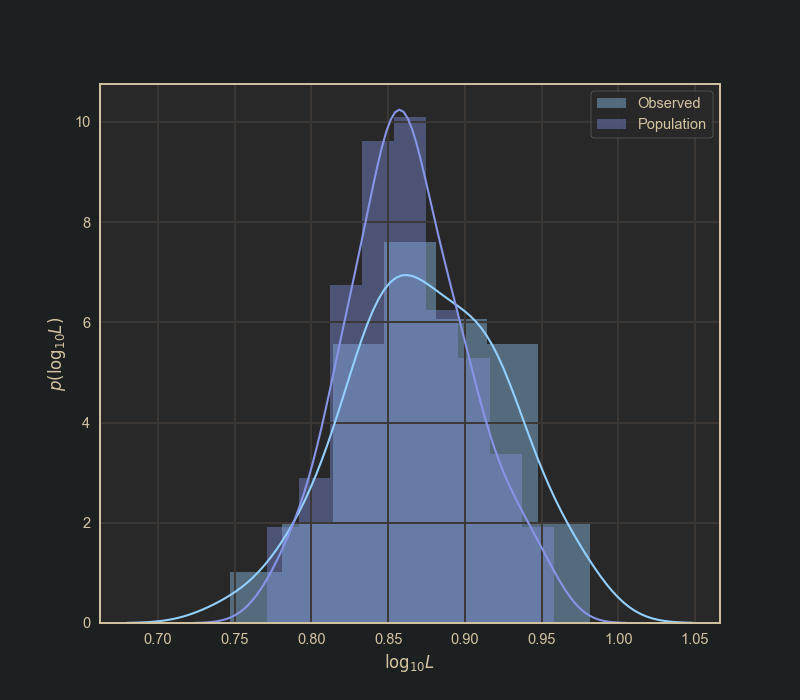

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'$p\\left( \\log_{10} L\\right)$')

In [8]:
fig, ax = plt.subplots()

sns.distplot(np.log10(Ls), label="Observed")
sns.distplot(np.log10(draw_luminosity(mu_true, sigma_true, size=100)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} L$')
ax.set_ylabel(r'$p\left( \log_{10} L\right)$')

<IPython.core.display.Javascript object>


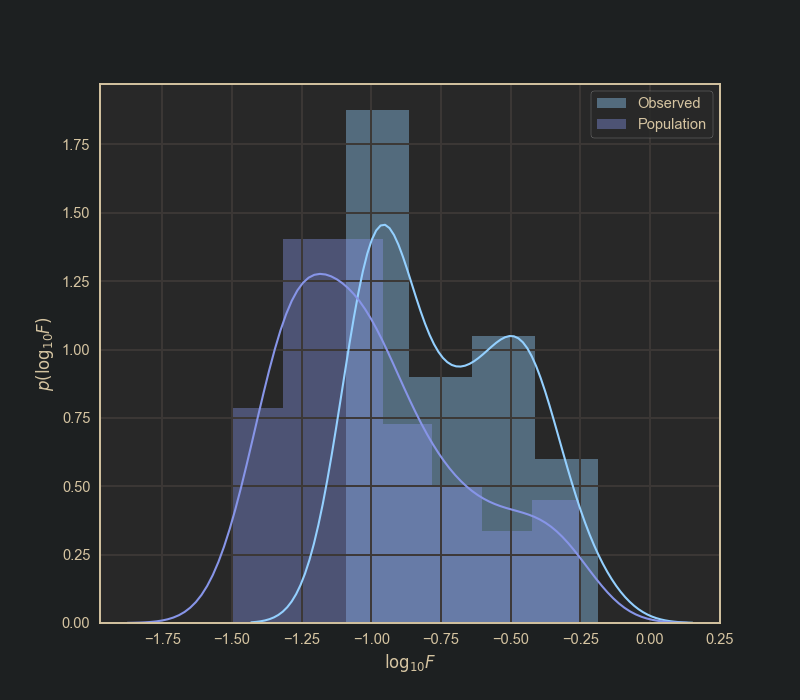

Text(0,0.5,'$p\\left( \\log_{10} F\\right)$')

In [32]:
fig, ax = plt.subplots()

sns.distplot(np.log10(Fobs), label="Observed")
nn=100
zzz= draw_redshift(zmax,size=nn)
sns.distplot(np.log10(draw_fobs(draw_luminosity(mu_true, sigma_true, size=nn),zzz,size=nn)), label='Population')
ax.legend(loc='best')
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10} F$')
ax.set_ylabel(r'$p\left( \log_{10} F\right)$')

<IPython.core.display.Javascript object>


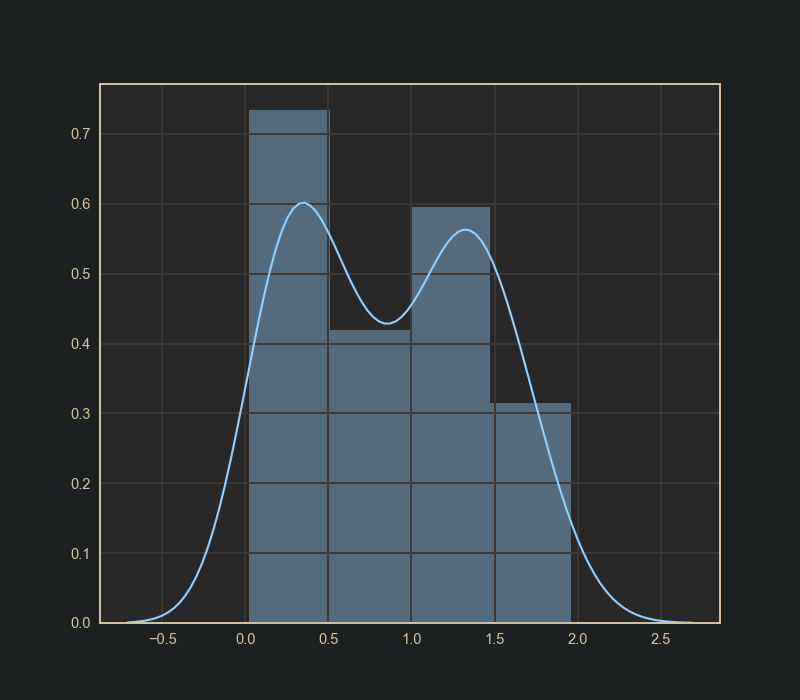

In [9]:
fig, ax = plt.subplots()

sns.distplot(zobs)


<IPython.core.display.Javascript object>


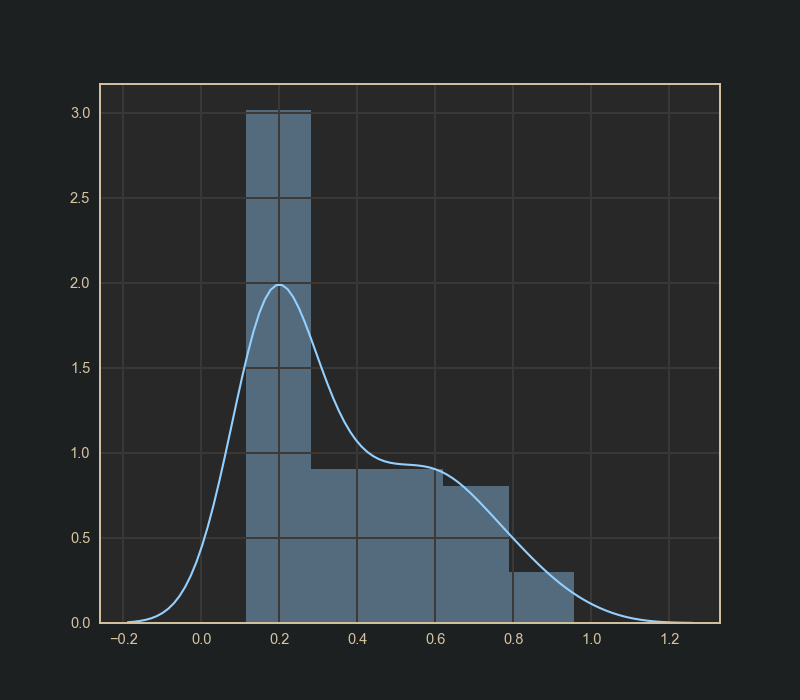

In [34]:
fig, ax = plt.subplots()

sns.distplot(1./((1+zobs)**2))

In [10]:
model_uk = pystan.StanModel(file='gaussian_ukz.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_62b9c5682c0f8860a92c147bbe5fd515 NOW.


In [11]:
fit_ukz = model_uk.sampling(
    data = {'Nobs': len(Ls), 
            'Fobs': Fobs,
            #'zobs': zobs,
            'NNobs_max': 100, 
            'Funcert': 0.05, 
            'zmax': zmax,
            'Fth': Fth},
    iter = 32000,
    chains=4,
    #warmup=4000,
    thin = 4,
    seed=1234
)

/home/jburgess/.venv/science/local/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


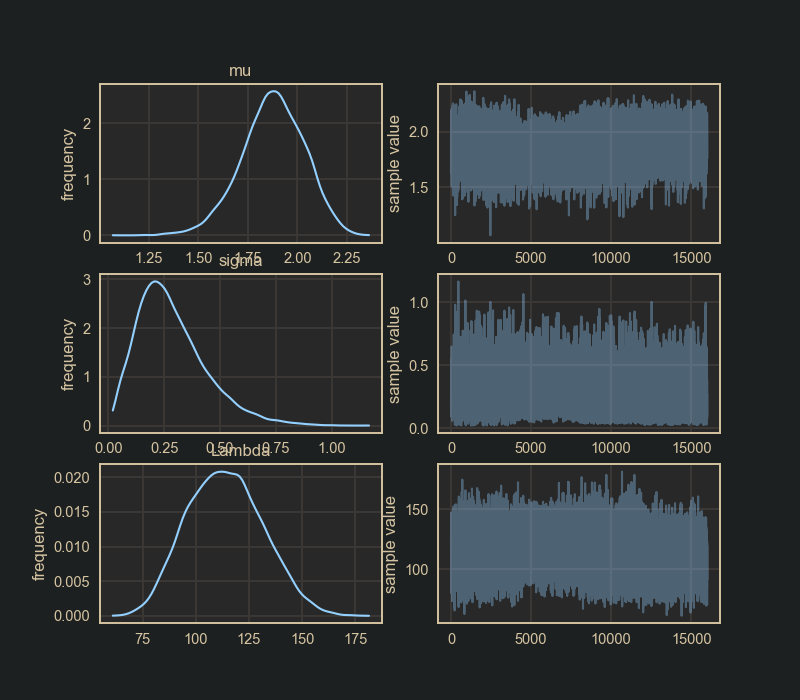

In [31]:
fit_ukz.plot(['mu', 'sigma', 'Lambda']);

<IPython.core.display.Javascript object>


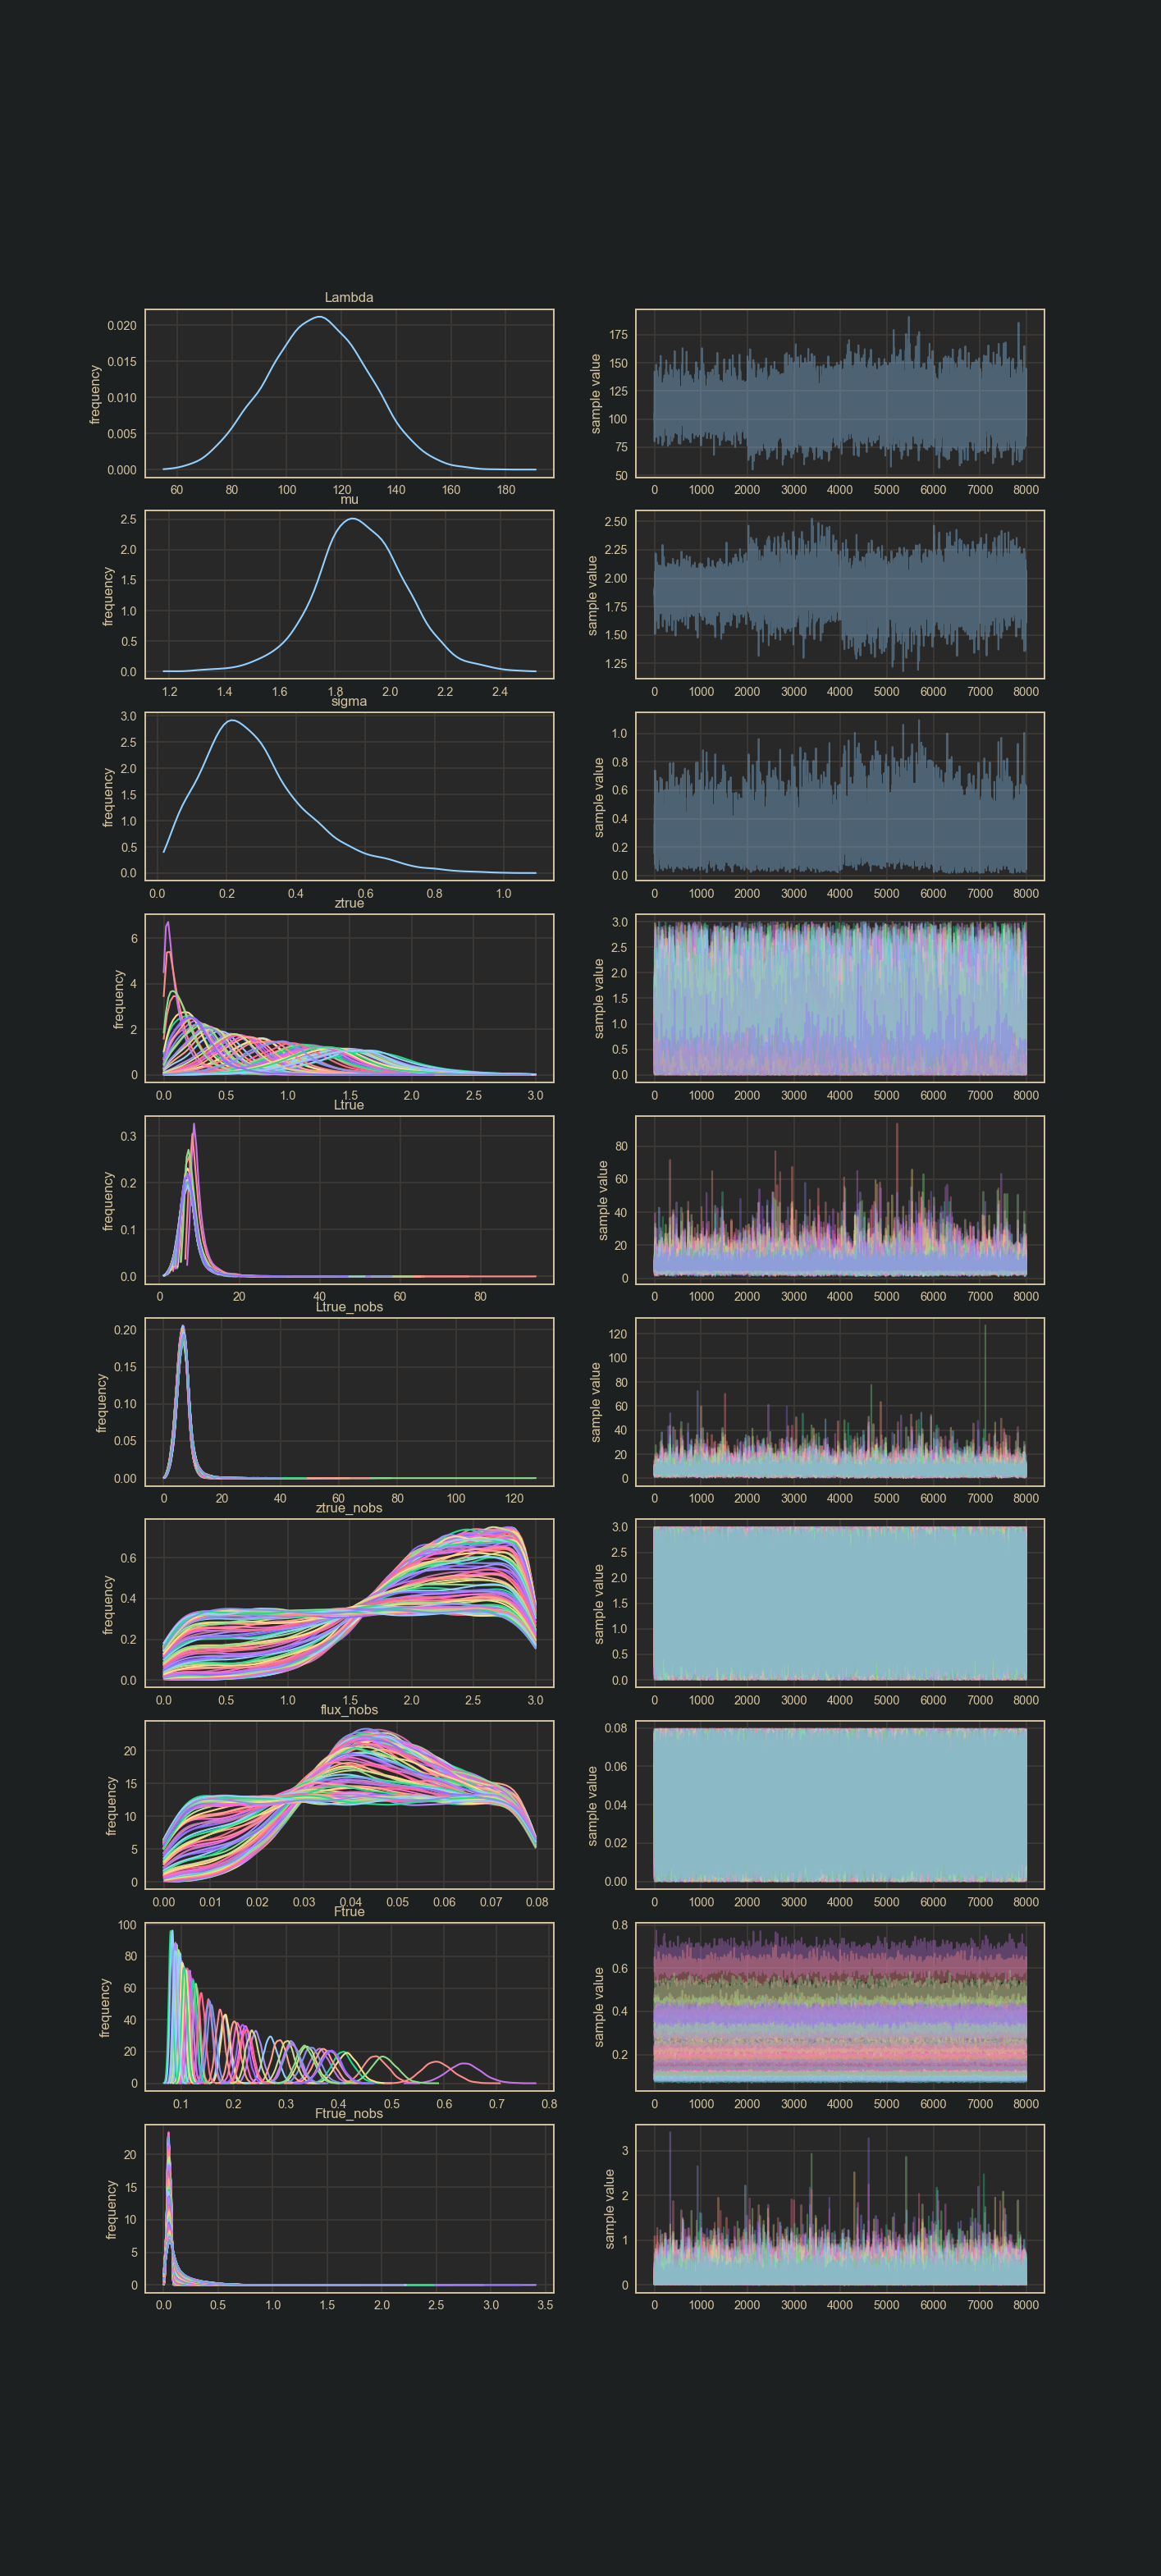

In [42]:
fit_ukz.plot();

In [12]:
chain_selected = fit_ukz.extract(permuted=True)

<IPython.core.display.Javascript object>


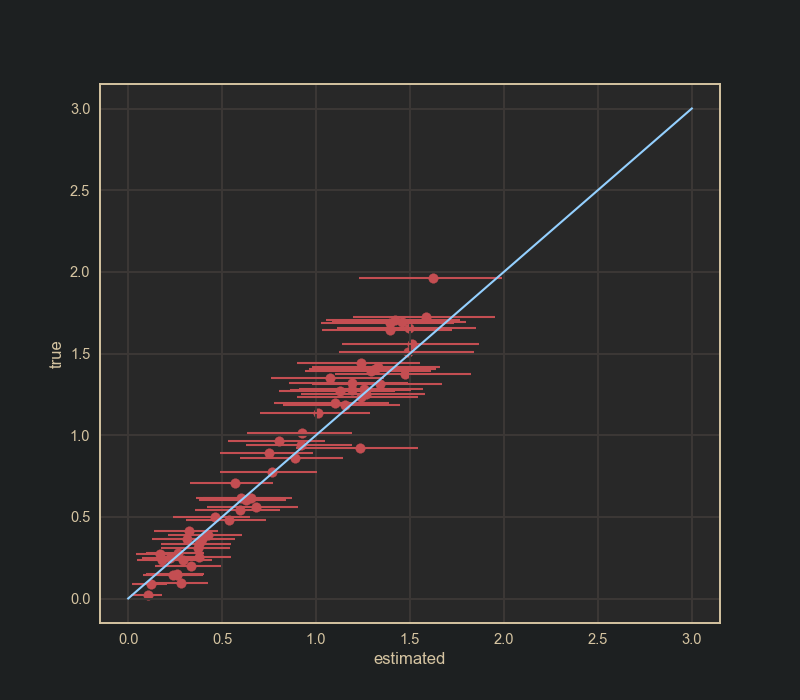

Text(0,0.5,'true')

In [16]:
fig, ax = plt.subplots()

ax.scatter(chain_selected['ztrue'].mean(axis=0),zobs,c='r')

ax.plot([0,3], [0,3])


ax.hlines(zobs, np.percentile(chain_selected['ztrue'], 16, axis=0),
          np.percentile(chain_selected['ztrue'], 84, axis=0),colors='r')

ax.set_xlabel('estimated')
ax.set_ylabel('true')

<IPython.core.display.Javascript object>


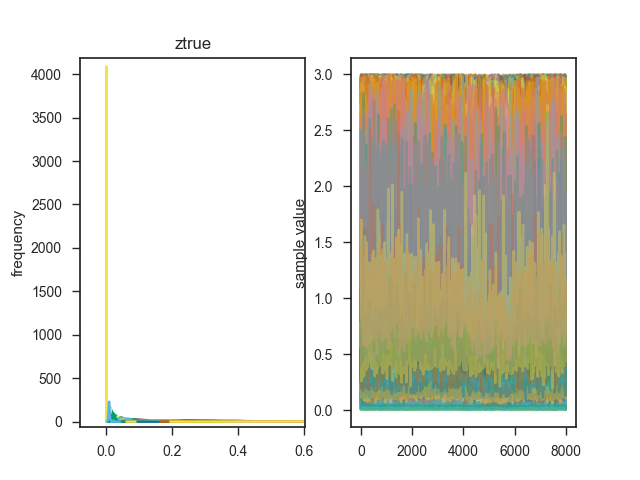

In [36]:
fit_ukz.plot(['ztrue']);

In [16]:
Ls

array([2.33817457, 2.56546558, 2.60415628, 3.08512948, 2.55004193,
       2.60023494, 2.60274035, 2.82531154, 2.47543618, 2.9763881 ,
       2.98245338, 2.67149017, 2.71905554, 2.91194799, 2.48941157,
       2.28698201, 2.61407425, 2.71506787, 2.8328725 , 3.40013227,
       2.50977655, 3.02506203, 3.02508523, 2.80506637, 2.50148487,
       2.19831238, 3.0818305 , 3.20943609, 2.526295  , 2.76335114,
       2.43889047, 2.89853509, 3.5248236 , 2.83662415, 2.6044774 ,
       3.0780213 , 2.37003602, 2.64433971, 2.75130333, 2.85032987,
       2.5692335 , 2.57308223, 2.62373792, 2.50341765, 2.75390938,
       2.66123949, 2.84518215, 2.65390761, 2.25311372, 2.67963985,
       2.75495933, 2.91668415, 2.90538335, 2.64470715, 2.44758257,
       2.83009023, 3.14934009, 2.75659938, 2.57316276, 2.10495595,
       2.62352164, 2.82683702, 2.65967883, 2.5604665 , 2.71656788,
       2.48052267, 2.69252589, 2.88047198, 2.88051466, 2.35936325,
       2.82063478, 2.39751583, 2.65243919, 2.3587396 , 2.49292

In [66]:
fit_ukz

Inference for Stan model: anon_model_4a733275e9b22a1113dd4760c0f8bf95.
4 chains, each with iter=32000; warmup=16000; thin=8; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Lambda         104.93   18.98  32.87  51.95  76.85 102.71 133.45 162.14    3.0   2.32
mu               0.99    0.46   0.65  -0.04   0.41   0.95   1.55   2.12    2.0   2.54
sigma            0.35    0.05   0.27   0.04   0.14   0.28    0.5   1.05   30.0   1.08
ztrue[0]         0.88    0.17   0.33    0.4   0.61   0.82   1.11   1.56    4.0   1.47
ztrue[1]         1.72    0.34   0.58   0.79   1.23   1.66    2.2   2.86    3.0   1.64
ztrue[2]         1.32    0.28   0.48    0.6   0.92   1.26   1.68   2.33    3.0   1.55
ztrue[3]         0.57    0.11   0.21   0.26    0.4   0.54   0.72   1.01    4.0   1.45
ztrue[4]         0.27    0.05   0.11   0.12   0.19   0.26   0.35    0.5    4.0    1.4
ztrue[5]         1.43    0.29    0.